In [43]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import glob
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
f = open('extract_img/labels.plk', 'rb')
labels_p = pickle.load(f)   
transform = T.Compose([
                       T.ToTensor(),
                      T.Resize(36)])

####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'extract_img/pics_split/train' 
test_data_path = 'extract_img/pics_split/test' 

train_folder_paths = []


for data_path in glob.glob(train_data_path + '/*'):
    train_folder_paths.append(data_path)
    

# create the test_image_paths
test_folder_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_folder_paths.append(data_path)

test_folder_paths = sorted(test_folder_paths)

train_folder_paths = sorted(train_folder_paths)

seq_l=6
def imagesToSeq(seq_l,fol_path):
    
    image_seq=[]
    for fol in fol_path:
        image_paths=sorted(glob.glob(fol + '/*'))
        im_list=[]
        for i in range(8-seq_l+1):
            im_list2=[]
            for j in range(seq_l):
                im_list2.append(image_paths[i+j])
            im_list.append(im_list2)
        image_seq.append(im_list)
    image_seq= np.asarray(image_seq).reshape((len(image_seq)* (8-seq_l+1)),seq_l)
    return image_seq
    
    
train_seq=imagesToSeq(seq_l,train_folder_paths)        
test_seq=imagesToSeq(seq_l,test_folder_paths)             

class imgDataset(Dataset):
    def __init__(self, seq_paths,seq_len, transform=False):
        self.seq_paths = seq_paths
        self.transform = transform
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.seq_paths)

    def __getitem__(self, idx):
        images=[]
        labels=[]
        sq=self.seq_paths[idx]
        
        for i in range(self.seq_len):
            
            image_filepath = sq[i]
            
            image = cv2.imread(image_filepath)
            image = self.transform(image)
            images.append(image)

            indx=int(image_filepath.split('/')[-1].split('.')[-2])
            row=int(image_filepath.split('/')[-2])   
            label=(labels_p[row][indx])/10
            labels.append(torch.tensor(label))

        images = torch.stack(images)
        labels = torch.stack(labels)
        
        return images, labels 
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = imgDataset(train_seq,seq_l, transform)
test_dataset = imgDataset(test_seq,seq_l, transform)



#######################################################
#                  Define Dataloaders
#######################################################
batch_size = 16
train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)


test_dl = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [45]:
# Define relevant variables for the ML task

num_classes = 64
learning_rate = 0.001
num_epochs = 250

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(936, 256)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [47]:
model = LeNet5(num_classes).to(device)

#Setting the loss function

cost = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_dl)

loss 0 ===== 4.16549015045166
loss 1 ===== 4.149285316467285
loss 2 ===== 4.137945175170898
loss 3 ===== 4.104402542114258
loss 4 ===== 4.122012615203857
loss 5 ===== 4.112527370452881
loss 6 ===== 4.112313747406006
loss 7 ===== 4.124065399169922
loss 8 ===== 4.082400321960449
loss 9 ===== 4.087412357330322
loss 10 ===== 4.063029766082764
loss 11 ===== 4.100801944732666
loss 12 ===== 4.032370567321777
loss 13 ===== 4.053506851196289
loss 14 ===== 4.037025451660156
loss 15 ===== 4.071715354919434
loss 16 ===== 4.078179836273193
loss 17 ===== 4.040948390960693
loss 18 ===== 4.025528907775879
loss 19 ===== 4.03471565246582
loss 20 ===== 4.021620273590088
loss 21 ===== 4.008813858032227
loss 22 ===== 3.986469268798828
loss 23 ===== 3.96909761428833
loss 24 ===== 4.008079528808594
loss 25 ===== 3.9571902751922607
loss 26 ===== 4.014583587646484
loss 27 ===== 3.9336514472961426
loss 28 ===== 3.897212028503418
loss 29 ===== 3.936985969543457
loss 30 ===== 3.8585832118988037
loss 31 ===== 3.90

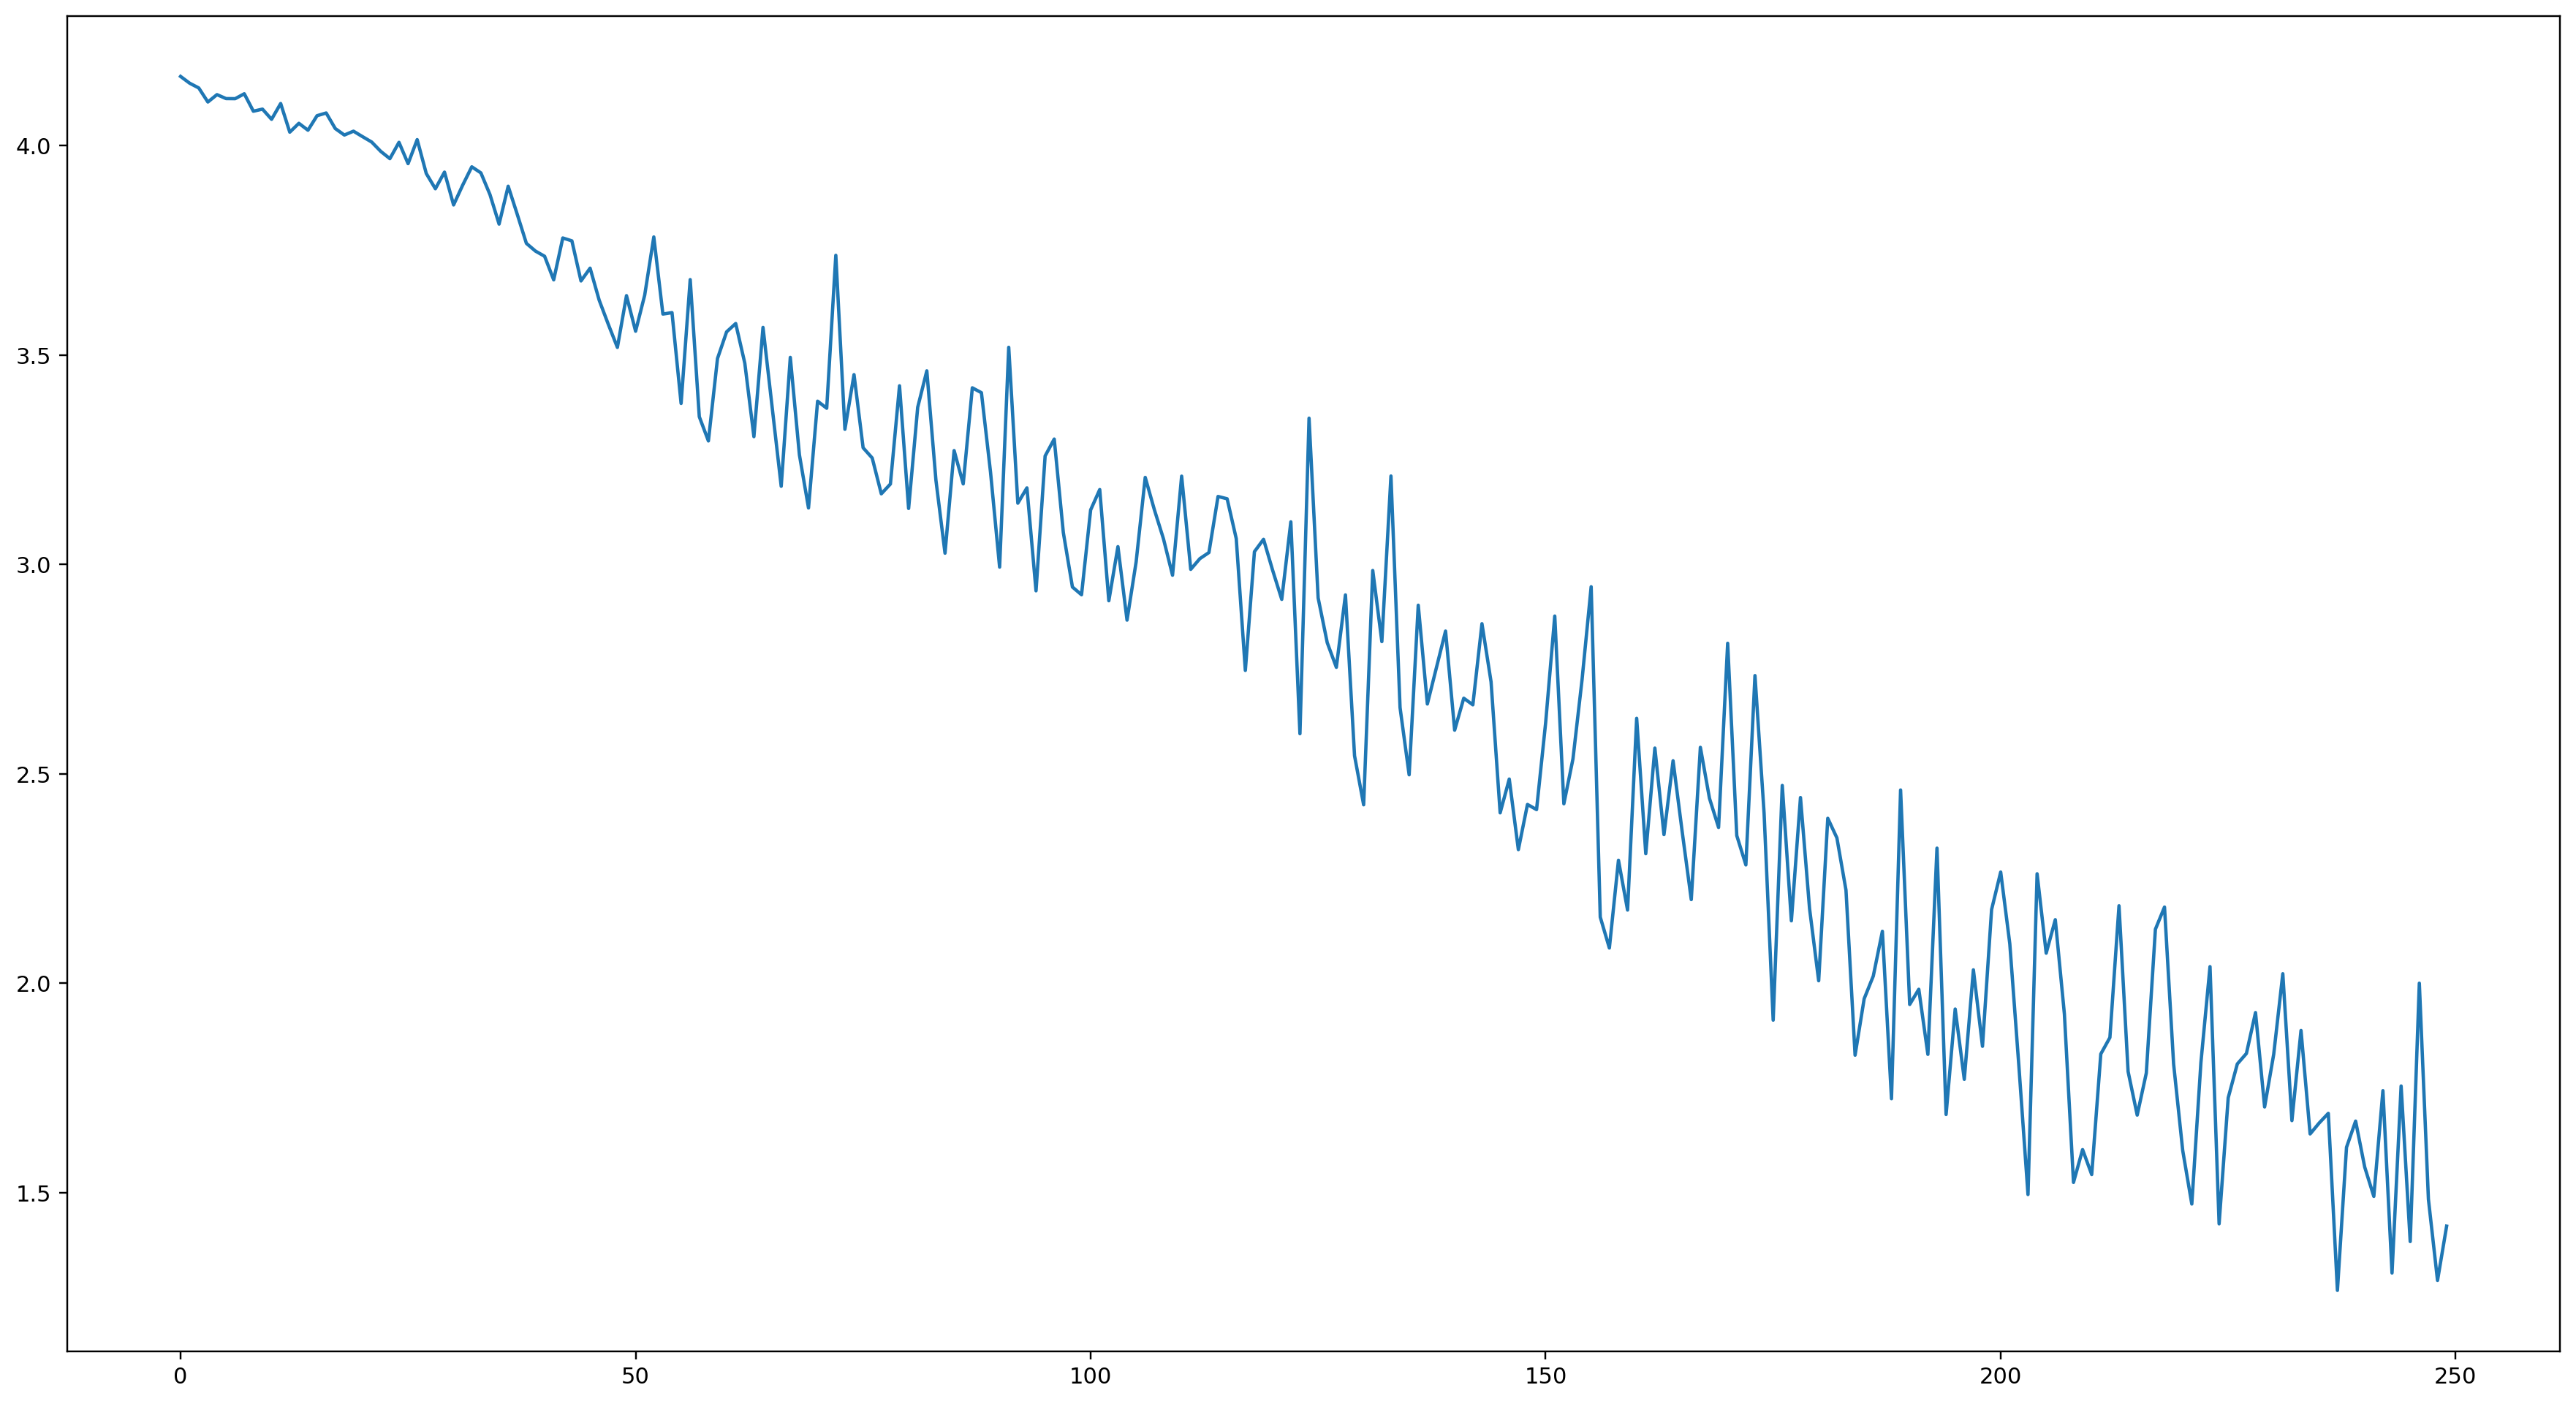

In [48]:
requires_grad=False
total_step = len(train_dl)
t_loss = []


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):  
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0]*seq_l,3,64,36))
        labels = labels.to(device).to(torch.long)
        labels = torch.flatten(labels)
        outputs = model(images)
        loss_v =[]
        loss=cost(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("loss",epoch,"=====",float(loss))    
    t_loss.append(float(loss))
    
figure(figsize=(20, 11), dpi=220)    
plt.plot(t_loss)    

/Users/mohamad/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


perfromance =  tensor(93.8945) %
MsE  =  41.444443
Accuracy: 52.85%


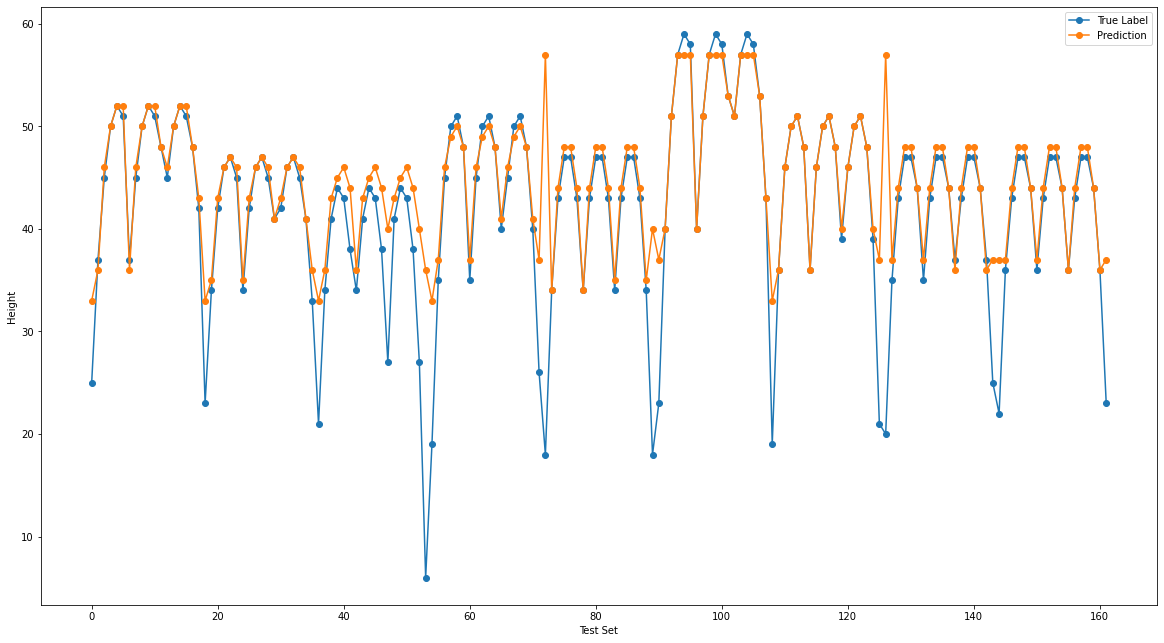

In [50]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
pred = []
pred = torch.tensor(pred)
targets = []
targets = torch.tensor(targets)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0]*seq_l,3,64,36))
        labels = labels.to(device).to(torch.long)
        labels = torch.flatten(labels)

        targets = torch.cat((targets,labels),0)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        pred = torch.cat((pred,predicted),0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
	 

figure(figsize=(20, 11))
plt.plot(targets,marker='o')
plt.plot(pred,marker='o')
plt.xlabel("Test Set")
plt.ylabel("Height")
plt.legend(["True Label","Prediction"])
# plt.savefig("result_cl")

MAE_svr = mean_absolute_error(targets,pred)
err_percent = (MAE_svr/targets.mean())*100
print('perfromance = ',100-err_percent,'%' )
mse = mean_squared_error(targets,pred)
print("MsE  = " , mse )

r2 = r2_score(targets, pred)

# Convert to a percentage
accuracy = r2 * 100

print("Accuracy: {:.2f}%".format(accuracy))